In [1]:
!pip install datasets
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:

import pandas as pd

# Step 3: Load the dataset
dataset = load_dataset("BothBosu/scam-dialogue")

# Step 4: Convert the dataset to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Drop 'generalisation' and 'label' columns
df.drop(columns=['label'], inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

Generating train split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [3]:
print(df)

                                               dialogue           type
0     caller: Hi, is John there? receiver: I think y...          wrong
1     caller: Hi, is this 555-1234? receiver: No, th...          wrong
2     caller: Hello, my name is John and I'm calling...        support
3     caller: Hello, my name is John and I'm calling...  telemarketing
4     caller: Hi, I'm calling from XYZ Delivery Serv...       delivery
...                                                 ...            ...
1275  caller: Hello, my name is John and I'm calling...  telemarketing
1276  caller: Hello, my name is John and I'm calling...      insurance
1277  caller: Hi, I'm calling from Speedy Delivery. ...       delivery
1278  caller: Hello, is this John Smith? receiver: Y...            ssn
1279  caller: Hi, is this 555-1234? receiver: Yes, i...          wrong

[1280 rows x 2 columns]


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the emotion labels
df['Emotion_encoded'] = label_encoder.fit_transform(df['type'])
df = df.drop(columns=['type'])
# Display the first few rows to verify the new column
print(df.head())

                                            dialogue  Emotion_encoded
0  caller: Hi, is John there? receiver: I think y...                7
1  caller: Hi, is this 555-1234? receiver: No, th...                7
2  caller: Hello, my name is John and I'm calling...                5
3  caller: Hello, my name is John and I'm calling...                6
4  caller: Hi, I'm calling from XYZ Delivery Serv...                0


In [5]:
intent="Emotion_encoded"
utterance='dialogue'

In [6]:
print(df[intent].value_counts())

Emotion_encoded
7    160
5    160
6    160
0    160
2    160
3    160
4    160
1    160
Name: count, dtype: int64


In [7]:
num_unique_values = df[intent].nunique()
num_unique_values

8

In [8]:
print(df[intent].value_counts())

Emotion_encoded
7    160
5    160
6    160
0    160
2    160
3    160
4    160
1    160
Name: count, dtype: int64


In [9]:
# Define the train, validation, and test splits
train_df = df.iloc[:int(len(df) * 0.5)]
validation_df = df.iloc[int(len(df) * 0.5):int(len(df) * 0.8)]
test_df = df.iloc[int(len(df) * 0.8):]

# Save the splits to separate files
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [10]:
print(train_df[intent].value_counts())

Emotion_encoded
2    90
4    87
0    82
3    80
6    79
7    77
1    77
5    68
Name: count, dtype: int64


In [11]:
# import pandas as pd

# # Assuming your dataframe is named 'df' and the column containing labels is named 'label'

# # Count occurrences of each class
# class_counts = train_df[intent].value_counts()

# # Find the count of the lowest class
# lowest_count = class_counts.min()

# # Resample each class to have the same count as the lowest class
# train_df = train_df.groupby(intent).apply(lambda x: x.sample(lowest_count)).reset_index(drop=True)

# # Shuffle the rows of the DataFrame
# train_df = train_df.sample(frac=1).reset_index(drop=True)

# # Verify that each class now has the same count
# print(train_df[intent].value_counts())


In [12]:
# Save the shuffled DataFrame to a CSV file
train_df.to_csv('train.csv', index=False)

In [13]:
len(train_df)

640

In [14]:
import torch
from torch.utils.data import Dataset


class Dataset_Div_tr_val_test(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data[utterance]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index][intent]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [15]:
!pip install tiktoken>=0.5.1

In [16]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [17]:
train_dataset = Dataset_Div_tr_val_test(
    csv_file="train.csv",
    max_length=120,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = Dataset_Div_tr_val_test(
    csv_file="validation.csv",
    max_length=120,
    tokenizer=tokenizer
)
test_dataset = Dataset_Div_tr_val_test(
    csv_file="test.csv",
    max_length=120,
    tokenizer=tokenizer
)

120


In [18]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 32

torch.manual_seed(123)


val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,

)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,

)

In [19]:
# this is for global client
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

In [20]:
# print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

12 validation batches
8 test batches


In [21]:
print(train_df)

                                              dialogue  Emotion_encoded
0    caller: Hi, is John there? receiver: I think y...                7
1    caller: Hi, is this 555-1234? receiver: No, th...                7
2    caller: Hello, my name is John and I'm calling...                5
3    caller: Hello, my name is John and I'm calling...                6
4    caller: Hi, I'm calling from XYZ Delivery Serv...                0
..                                                 ...              ...
635  caller: Hello, is this 555-1234? receiver: Yes...                7
636  caller: Hello, my name is John and I'm calling...                1
637  caller: Hi, I'm calling from XYZ Delivery Serv...                0
638  caller: Hi, I'm calling from XYZ Delivery Serv...                0
639  caller: Hello, my name is John and I'm calling...                1

[640 rows x 2 columns]


In [22]:
client_train_loaders = []
def localtrainloader(num_clients):

    num_samples_per_client = len(train_dataset) // num_clients  # Number of samples per client

    for client_idx in range(num_clients):
        # Determine the start and end indices for this client's subset of the dataset
        start_idx = client_idx * num_samples_per_client
        end_idx = (client_idx + 1) * num_samples_per_client

        # Create a Subset of the dataset for this client
        subset = torch.utils.data.Subset(train_dataset, range(start_idx, end_idx))

        # Create a DataLoader for this client's subset
        client_train_loader = DataLoader(
            dataset=subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=True
        )

        # Append the DataLoader for this client to the list
        client_train_loaders.append(client_train_loader)


In [23]:
# # Assuming client_idx is the index of the client (0-indexed)
# localtrainloader(9)
# client_idx = 0  # Change this to the client's index

# # Access the DataLoader for the client
# client_0_train_loader = client_train_loaders[client_idx]

In [24]:
# print("Train loader:")
# for input_batch, target_batch in client_0_train_loader:
#     pass

# print("Input batch dimensions:", input_batch.shape)
# print("Label batch dimensions", target_batch.shape)



---


### Model

In [25]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [26]:
!git clone https://github.com/rasbt/LLMs-from-scratch.git

Cloning into 'LLMs-from-scratch'...
remote: Enumerating objects: 2833, done.
remote: Counting objects: 100% (834/834), done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 2833 (delta 658), reused 540 (delta 526), pack-reused 1999
Receiving objects: 100% (2833/2833), 9.41 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (1739/1739), done.


In [27]:
import sys
sys.path.append('LLMs-from-scratch/ch06/01_main-chapter-code')
sys.path.append('LLMs-from-scratch/ch06/')  # add this line

from gpt_download import *
from previous_chapters import *

In [28]:

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 50.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 640kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 61.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:48<00:00, 10.2MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.74MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 366kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 362kiB/s]


In [29]:
torch.manual_seed(123)

num_classes = 8
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
x=0



---

### LoRA

In [30]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [31]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [32]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

In [33]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,445,960
Total trainable parameters after: 0


In [34]:
replace_linear_with_lora(model, rank=8, alpha=8)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 1,333,312


In [35]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [36]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# Suppress the specific UserWarning
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

In [37]:
import torch
import torch.nn as nn

class FirstPartModel(nn.Module):
    def __init__(self, original_model, split_layer):
        super(FirstPartModel, self).__init__()
        self.embed_tokens1 = original_model.tok_emb
        self.embed_tokens2 = original_model.pos_emb
        self.embed_tokens3 = original_model.drop_emb
        self.layers = nn.ModuleList(original_model.trf_blocks[:split_layer])

    def forward(self, input_ids, **kwargs):
        batch_size, seq_len = input_ids.shape
        x1 = self.embed_tokens1(input_ids)
        x2 = self.embed_tokens2(torch.arange(seq_len, device=input_ids.device))
        x=x1+x2
        x = self.embed_tokens3(x)
        for layer in self.layers:
            x = layer(x, **kwargs)
        return x




In [38]:
class SecondPartModel(nn.Module):
    def __init__(self, original_model, split_layer):
        super(SecondPartModel, self).__init__()
        self.layers = nn.ModuleList(original_model.trf_blocks[split_layer:])
        self.final_norm = original_model.final_norm
        self.out_head = original_model.out_head

    def forward(self, x, **kwargs):
        for layer in self.layers:
            x = layer(x, **kwargs)
            #print(x)

        logits = self.final_norm(x)
        logits = self.out_head(logits)
        return logits

In [39]:
split_layer = 2
first_part_model = FirstPartModel(model, split_layer)
second_part_model = SecondPartModel(model, split_layer)

In [40]:
torch.cuda.is_available()

True

In [41]:
testmodel=FirstPartModel(model, split_layer)

In [42]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
second_part_model.to(device)
def predict(logits,target_batch,x):
    second_part_model.train()
    logits = torch.tensor(logits).to(device)
    logits=logits.clone().detach().requires_grad_(True)
    target_batch = torch.tensor(target_batch).to(device)
    # optimizer2 = torch.optim.AdamW(list(second_part_model.parameters()), lr=2e-4)
    optimizer2 = torch.optim.AdamW(list(second_part_model.parameters()), lr=1e-5)
    optimizer2.zero_grad()
    logits_secondPart = second_part_model(logits)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits_secondPart, target_batch)
    if(x==0):
      loss.backward()
      optimizer2.step()
      dfx_client = logits.grad.clone().detach()
      dfx_client = torch.tensor(dfx_client).to(device)
      return  dfx_client,loss
    else:
      return 0,loss


def logits1(logits_input):
    second_part_model.eval()
    logits_tensor = torch.tensor(logits_input).to(device)
    with torch.no_grad():
        logits_output = second_part_model(logits_tensor)[:, -1, :]
    return logits_output

def inference(logits):
    logits = torch.tensor(logits).to(device)
    logits_secondPart = second_part_model(logits)[:, -1, :]
    return logits_secondPart

def saveweightsserver():
    torch.save(second_part_model.state_dict(), 'second_part_model_weights.pth')



In [43]:

def send_request(logits, target_batch,x):
    logits_np = logits.detach().cpu()
    target_batch_np = target_batch.detach().cpu()
    gradients,loss=predict(logits_np,target_batch_np,x)
    return gradients, loss


def send_request2(logits):
    logits_np = logits.detach().cpu()
    result=logits1(logits)
    return result


def calc_loss_batch_client(input_batch, target_batch, device, client_model,x):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = client_model(input_batch)
    gradient_values, loss = send_request(logits,target_batch,x)
    if gradient_values is not None:
       return gradient_values, loss, logits
    else:
      return torch.tensor(0.0, device=device, requires_grad=True)
    return gradient_values



In [44]:
@torch.no_grad() # Disable gradient tracking for efficiency
def calc_accuracy_loader(data_loader, device,client_model, num_batches=None):
    client_model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = client_model(input_batch)
            logits = send_request2(logits)
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [45]:
#Client
def evaluate_model_client( train_loader, val_loader, device,client_model, eval_iter):
    client_model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader_client(train_loader, device,client_model, num_batches=eval_iter)
        val_loss = calc_loss_loader_client(val_loader, device,client_model, num_batches=eval_iter)
    client_model.train()
    return train_loss, val_loss

def calc_loss_loader_client(data_loader,device,client_model,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            x=1
            _, loss, _ = calc_loss_batch_client(input_batch, target_batch, device,client_model,1)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches



def train_classifier_simple_client( train_loader, val_loader, optimizer, device,client_model, epochs,
                            eval_freq, eval_iter, tokenizer, num_epochs,client_number):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1


    for epoch in range(epochs):
        client_model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            gradient_values, loss, logits = calc_loss_batch_client(input_batch, target_batch, device,client_model,0)
            logits.backward(gradient_values)
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1


            #Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model_client(
                    train_loader, val_loader, device,client_model,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Client {client_number+1} Ep {num_epochs+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(train_loader, device,client_model, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, device,client_model, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [46]:
def saveweights(client_model):
  torch.save(client_model.state_dict(), 'first_part_model_weights.pth')
  saveweightsserver()


In [47]:
def FedAvg(w):
    w_avg = (w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [48]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [49]:
first_part_model.to(device)
train_accuracy = calc_accuracy_loader(train_loader, device,first_part_model)
val_accuracy = calc_accuracy_loader(val_loader, device,first_part_model)
test_accuracy = calc_accuracy_loader(test_loader, device,first_part_model)
print(f"\nTraining accuracy2: {train_accuracy*100:.2f}%")
print(f"Validation accuracy2: {val_accuracy*100:.2f}%")
print(f"test accuracy2: {val_accuracy*100:.2f}%")


Training accuracy2: 11.88%
Validation accuracy2: 11.98%
test accuracy2: 11.98%


In [50]:
import time
import numpy as np
import copy
first_part_model.to(device)
start_time = time.time()
torch.manual_seed(123)
# Initialize global model and state dict
w_glob_client=first_part_model.state_dict()

# Use a loop to add 9 clients
value=4
localtrainloader(value)
clients = []
for _ in range(value):
    clients.append((first_part_model))
optimizers = [torch.optim.AdamW(list(client.parameters()), lr=1e-5) for client in clients]
loader_train = [client_train_loaders[i] for i in range(value)]

train_losses_all = [[] for _ in range(value)]
val_losses_all = [[] for _ in range(value)]
train_accs_all = [[] for _ in range(value)]
val_accs_all = [[] for _ in range(value)]
examples_seen_all = [[] for _ in range(value)]

global_model_Training_accuracies = []
global_model_Validation_accuracies = []
global_model_Test_accuracies = []
global_model_train_loses = []
global_model_validation_loses = []
num_epochs = 20
for epoch in range(num_epochs):
    m = max(int(1 * value), 1)
    idxs_users = np.random.choice(range(value), m, replace = False)
    w_locals_client = []
    for idx in idxs_users:
        clients[idx]=copy.deepcopy(first_part_model)
        train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple_client(
            loader_train[idx], val_loader, optimizers[idx], device, clients[idx],
            epochs=1, eval_freq=50, eval_iter=15,
            tokenizer=tokenizer,num_epochs=epoch,client_number=idx)
        w_locals_client.append(copy.deepcopy(clients[idx].state_dict()))

        # Append metrics to corresponding client's list
        train_losses_all[idx].extend(train_losses)
        val_losses_all[idx].extend(val_losses)
        train_accs_all[idx].extend(train_accs)
        val_accs_all[idx].extend(val_accs)
        examples_seen_all[idx].append(examples_seen)

    print("\nComplete One Epoch\n")

    glob_client = FedAvg(w_locals_client)
    first_part_model.load_state_dict(glob_client)
    global_model_Training_accuracy  = calc_accuracy_loader(train_loader, device,first_part_model,num_batches=15) #, global_model_loss
    global_model_Validation_accuracy =  calc_accuracy_loader(val_loader, device,first_part_model,num_batches=15)
    global_model_Test_accuracy =  calc_accuracy_loader(test_loader, device,first_part_model,num_batches=15)
    global_model_Training_accuracies.append(global_model_Training_accuracy)
    global_model_Validation_accuracies.append(global_model_Validation_accuracy)
    global_model_Test_accuracies.append(global_model_Test_accuracy)
    global_train_loss,global_validation_loss = evaluate_model_client( train_loader, val_loader, device,first_part_model, eval_iter=5)
    global_model_train_loses.append(global_train_loss)
    global_model_validation_loses.append(global_validation_loss)

saveweights(first_part_model)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Client 3 Ep 1 (Step 000000): Train loss 8.788, Val loss 7.819
Training accuracy: 8.75% | Validation accuracy: 12.50%
Client 4 Ep 1 (Step 000000): Train loss 5.777, Val loss 6.358
Training accuracy: 17.50% | Validation accuracy: 12.24%
Client 1 Ep 1 (Step 000000): Train loss 4.815, Val loss 5.274
Training accuracy: 18.12% | Validation accuracy: 14.84%
Client 2 Ep 1 (Step 000000): Train loss 4.521, Val loss 4.440
Training accuracy: 15.00% | Validation accuracy: 16.15%

Complete One Epoch

Client 4 Ep 2 (Step 000000): Train loss 3.131, Val loss 3.770
Training accuracy: 20.62% | Validation accuracy: 15.89%
Client 2 Ep 2 (Step 000000): Train loss 3.008, Val loss 3.224
Training accuracy: 18.75% | Validation accuracy: 16.93%
Client 3 Ep 2 (Step 000000): Train loss 2.705, Val loss 2.870
Training accuracy: 21.25% | Validation accuracy: 17.97%
Client 1 Ep 2 (Step 000000): Train loss 2.324, Val loss 2.575
Training accuracy: 23.12% | Validation accuracy: 18.49%

Complete One Epoch

Client 3 Ep 3 (

In [51]:
import matplotlib.pyplot as plt

# Function to plot individual client values
def plot_individual_values(epochs_seen, examples_seen, train_values, val_values, client_num, label="loss"):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot training and validation values for the client
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax1.set_title(f"Client {client_num}")

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values[:len(examples_seen)], alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"client{client_num}_{label}-plot.pdf")
    plt.show()

# Function to plot combined values for all clients
def plot_combined_values(epochs_seen, examples_seen, train_values_list, val_values_list, label="loss"):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot training and validation values for each client
    for i, (train_values, val_values) in enumerate(zip(train_values_list, val_values_list), start=1):
        ax1.plot(epochs_seen, train_values, label=f"Client {i} Training {label}")
        ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Client {i} Validation {label}")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values_list[0][:len(examples_seen)], alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"all_clients_{label}-plot.pdf")
    plt.show()




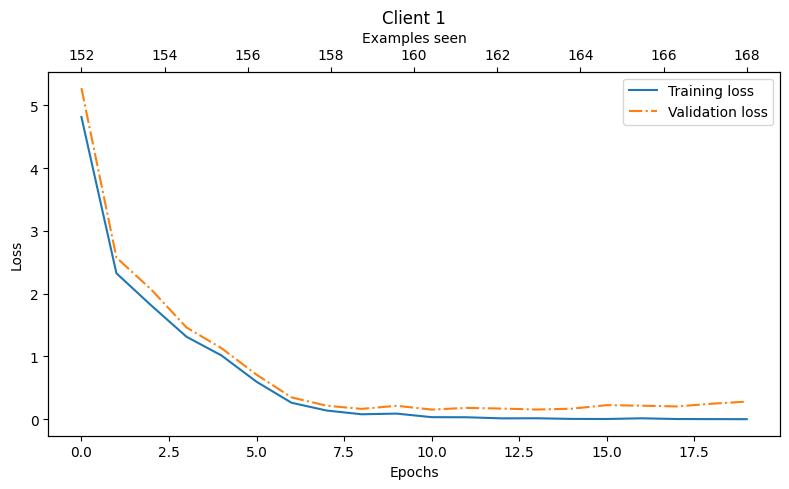

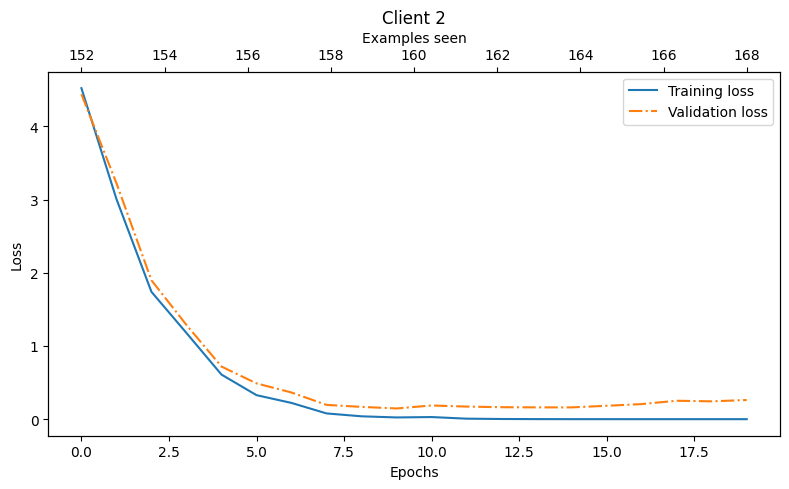

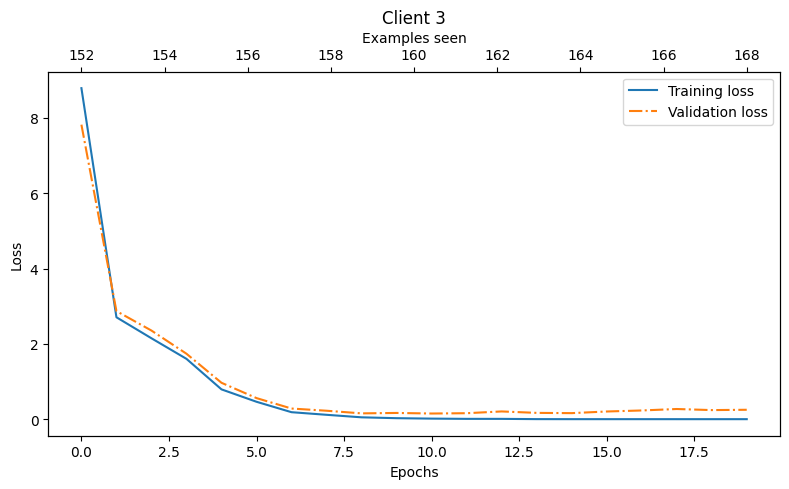

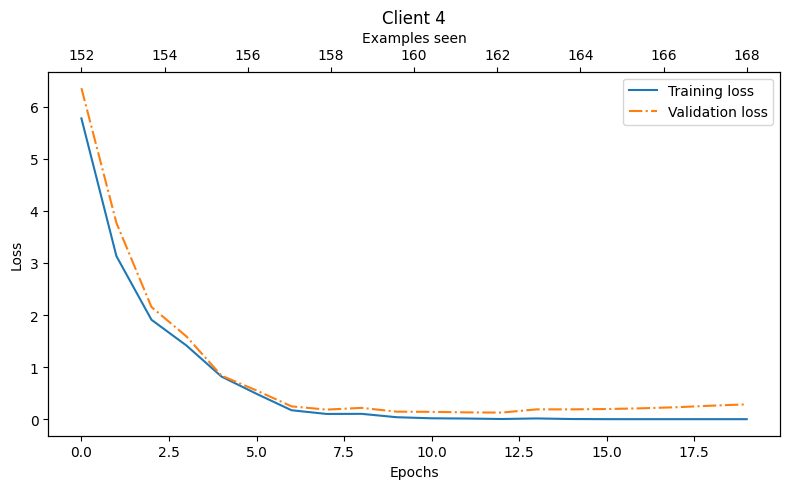

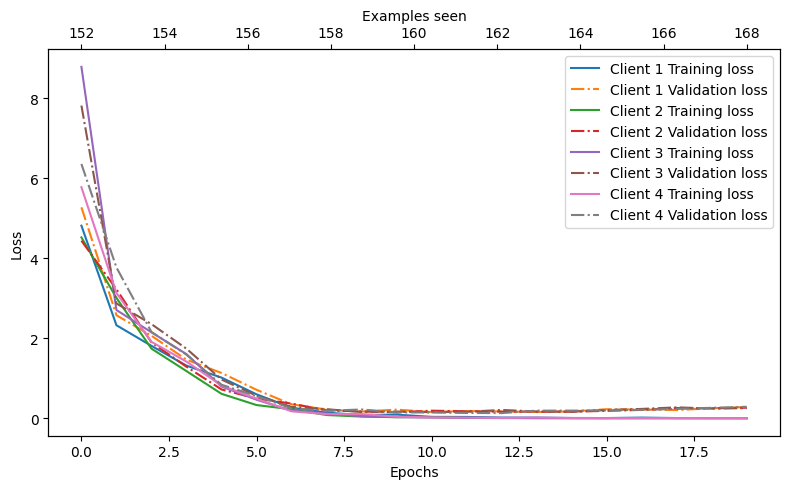

In [52]:
# Convert the metrics to tensors for plotting
train_losses_all_tensor = [torch.tensor(train_losses) for train_losses in train_losses_all]
val_losses_all_tensor = [torch.tensor(val_losses) for val_losses in val_losses_all]
examples_seen_all_tensor = [torch.tensor(examples_seen) for examples_seen in examples_seen_all]

# Generate a linear space for epochs
num_epochs = len(train_losses_all[0])  # Assuming all clients have the same number of epochs
epochs_tensor = torch.linspace(0, num_epochs - 1, num_epochs)

# Plot each client's values separately
for i, (train_losses, val_losses, examples_seen) in enumerate(zip(train_losses_all, val_losses_all, examples_seen_all_tensor), start=1):
    plot_individual_values(epochs_tensor, examples_seen, train_losses, val_losses, i)

# Plot all clients' values together
plot_combined_values(epochs_tensor, examples_seen_all_tensor[0], train_losses_all_tensor, val_losses_all_tensor)

In [53]:
import matplotlib.pyplot as plt
import torch

# Function to plot individual client values
def plot_values(epochs_seen, examples_seen, train_values, val_values, client_num, label="accuracy"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation accuracy against epochs
    ax1.plot(epochs_seen, train_values, label=f"Client {client_num} Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Client {client_num} Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()



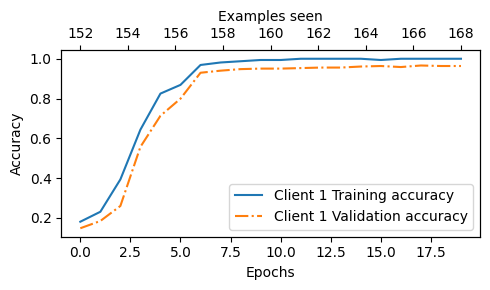

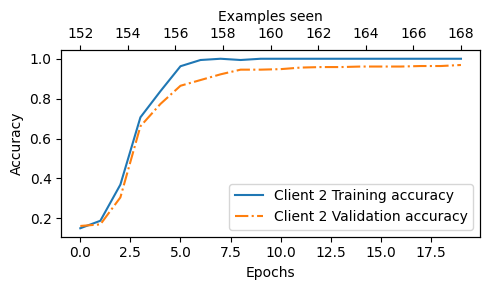

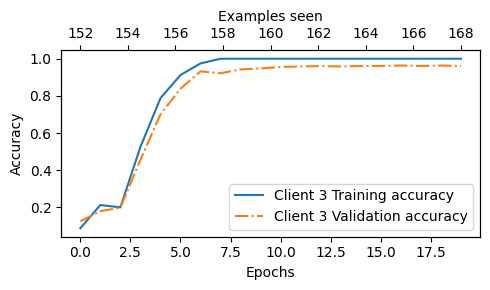

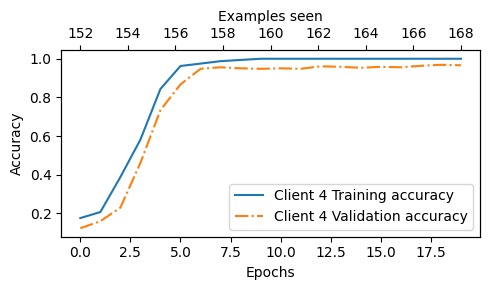

In [54]:
clients_data = [(train_accs_client, val_accs_client, examples_seen_client) for train_accs_client, val_accs_client, examples_seen_client in zip(train_accs_all, val_accs_all, examples_seen_all)]

# Generate a linear space for epochs
num_epochs = len(train_accs_all[0])  # Assuming all clients have the same number of epochs
epochs_tensor = torch.linspace(0, num_epochs - 1, num_epochs)

# Plot values for each client separately
for i, (train_accs, val_accs, examples_seen) in enumerate(clients_data, start=1):
    examples_seen_tensor = torch.tensor(examples_seen)  # Convert examples_seen to tensor
    plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, i)

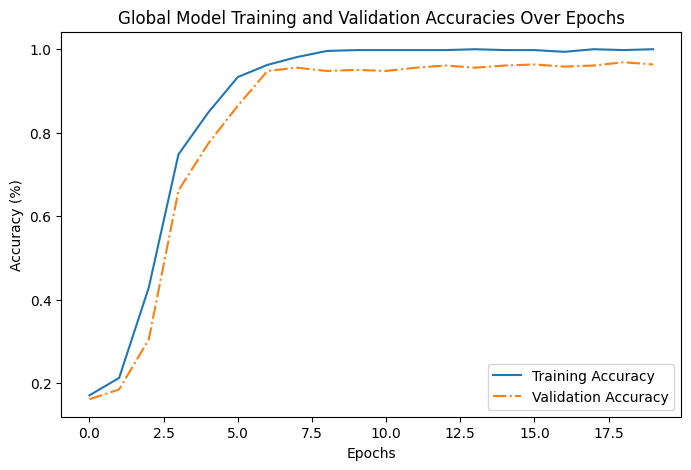

In [55]:
def plot_global_accuracies(epochs, train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", linestyle="-.")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Global Model Training and Validation Accuracies Over Epochs")
    plt.legend()
    plt.savefig("global_model_accuracies.pdf")
    plt.show()

# Generate a linear space for epochs
epochs_tensor = torch.linspace(0, num_epochs - 1, num_epochs)

# Plot global model accuracies
plot_global_accuracies(epochs_tensor, global_model_Training_accuracies, global_model_Validation_accuracies)


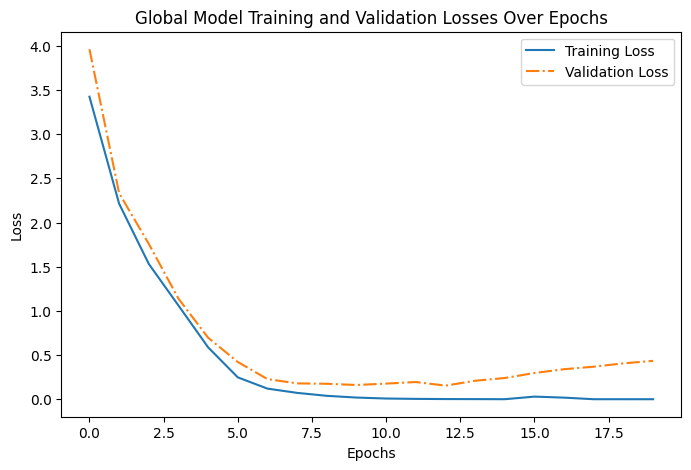

In [56]:
def plot_global_losses(epochs, train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss", linestyle="-.")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Global Model Training and Validation Losses Over Epochs")
    plt.legend()
    plt.savefig("global_model_losses.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs - 1, num_epochs)
# Plot global model losses
plot_global_losses(epochs_tensor, global_model_train_loses, global_model_validation_loses)



In [57]:
train_accuracy = calc_accuracy_loader(train_loader, device,first_part_model)
val_accuracy = calc_accuracy_loader(val_loader, device,first_part_model)
test_accuracy = calc_accuracy_loader(test_loader, device,first_part_model)
print(f"\nTraining accuracy2: {train_accuracy*100:.2f}%")
print(f"Validation accuracy2: {val_accuracy*100:.2f}%")
print(f"test accuracy2: {val_accuracy*100:.2f}%")



Training accuracy2: 100.00%
Validation accuracy2: 96.35%
test accuracy2: 96.35%


In [58]:
def classify_review(text,  tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = first_part_model(input_tensor)
        logits = inference(logits)  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Define the label mapping
    label_mapping = {
      0: "payment_issue",
      1: "create_account",
      2: "contact_customer_service",
      3: "get_invoice",
      4: "track_order",
      5: "get_refund",
      6: "contact_human_agent",
      7: "check_invoices",
      8: "recover_password",
      9: "change_order",
      10: "delete_account",
      11: "complaint",
      12: "review",
      13: "check_refund_policy"
    }

    # Return the classified result
    return label_mapping.get(predicted_label, "Unknown")

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_1 = (
    "I have a problem paying for my order, help me notify it"
)

print(classify_review(
    text_1, tokenizer, device, max_length=train_dataset.max_length
))

check_invoices


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_1 = (
    "I can't find my bills , I need help viewing them"
)

print(classify_review(
    text_1, tokenizer, device, max_length=train_dataset.max_length
))


check_invoices


In [61]:

# Convert the arrays to pandas DataFrames
train_losses_df = pd.DataFrame(train_losses_all)
val_losses_df = pd.DataFrame(val_losses_all)
train_accs_df = pd.DataFrame(train_accs_all)
val_accs_df = pd.DataFrame(val_accs_all)
examples_seen_df = pd.DataFrame(examples_seen_all)

# Save each DataFrame to an Excel file
train_losses_df.to_excel("train_losses.xlsx", index=False)
val_losses_df.to_excel("val_losses.xlsx", index=False)
train_accs_df.to_excel("train_accs.xlsx", index=False)
val_accs_df.to_excel("val_accs.xlsx", index=False)
examples_seen_df.to_excel("examples_seen.xlsx", index=False)

# Convert global model metrics to pandas DataFrame
global_metrics_df = pd.DataFrame({
    "Global Model Training Accuracy": global_model_Training_accuracies,
    "Global Model Validation Accuracy": global_model_Validation_accuracies,
    "Global Model Training Loss": global_model_train_loses,
    "Global Model Validation Loss": global_model_validation_loses
})

# Save global model metrics to an Excel file
global_metrics_df.to_excel("global_model_metrics.xlsx", index=False)
